# Define

In [1]:
import datajoint as dj
schema = dj.schema('university')

[2023-10-24 22:32:02,970][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-10-24 22:32:02,977][INFO]: Connected root@fakeservices.datajoint.io:3306


In [2]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned   # university-wide ID number
    ---
    first_name      : varchar(40)
    last_name       : varchar(40)
    sex             : enum('F', 'M', 'U')
    date_of_birth   : date
    home_address    : varchar(120) # mailing street address
    home_city       : varchar(60)  # mailing address
    home_state      : char(2)      # US state acronym: e.g. OH
    home_zip        : char(10)     # zipcode e.g. 93979-4979
    home_phone      : varchar(20)  # e.g. 414.657.6883x0881
    """

In [3]:
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # abbreviated department name, e.g. BIOL
    ---
    dept_name    : varchar(200)  # full department name
    dept_address : varchar(200)  # mailing address
    dept_phone   : varchar(20)
    """

In [4]:
@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> Department
    declare_date :  date  # when student declared her major
    """

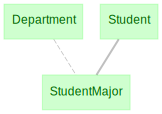

In [5]:
dj.Diagram(schema)

In [6]:
@schema
class Course(dj.Manual):
    definition = """
    -> Department
    course  : int unsigned   # course number, e.g. 1010
    ---
    course_name :  varchar(200)  # e.g. "Neurobiology of Sensation and Movement."
    credits     :  decimal(3,1)  # number of credits earned by completing the course
    """
    
@schema
class Term(dj.Manual):
    definition = """
    term_year : year
    term      : enum('Spring', 'Summer', 'Fall')
    """

@schema
class Section(dj.Manual):
    definition = """
    -> Course
    -> Term
    section : char(1)
    ---
    auditorium   :  varchar(12)
    """
    
@schema
class CurrentTerm(dj.Manual):
    definition = """
    -> Term
    """

@schema
class Enroll(dj.Manual):
    definition = """
    -> Student
    -> Section
    """

@schema
class LetterGrade(dj.Manual):
    definition = """
    grade : char(2)
    ---
    points : decimal(3,2)
    """

@schema
class Grade(dj.Manual):
    definition = """
    -> Enroll
    ---
    -> LetterGrade
    """

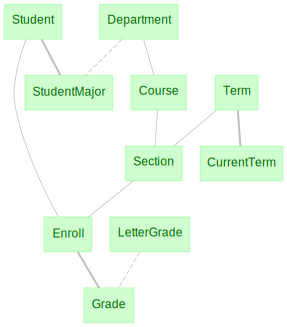

In [7]:
dj.Diagram(schema)

In [8]:
from tqdm import tqdm
import faker
import random
import itertools
import datetime
fake = faker.Faker()

In [9]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [10]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(100,300), yield_students()))

In [11]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,David,Warren,M,2007-05-28,328 Trevino Club,South Brittany,AR,85766,9867288695
101,Donald,Davis,M,2005-05-11,5507 Kevin Road Apt. 158,Jenniferhaven,PW,28061,384.891.3097x907
102,Logan,Carter,M,1991-06-06,80648 Phillips Manors Apt. 363,Carsonmouth,TN,89169,(931)654-8377
103,Andrea,Jones,F,1990-04-10,0728 Amy Plain,Millertown,ND,67142,+1-891-317-9091
104,Angela,Stevens,F,1990-02-19,67714 Hicks Courts Suite 791,Heidistad,IN,57838,721.306.0389x29709
105,Brittney,Meyer,F,1997-04-01,2533 Colon Vista Suite 094,East Gregoryton,IA,47281,512.492.0549
106,Scott,Ross,M,1990-06-29,1360 Vanessa Ports Apt. 444,East Andrewberg,CA,49351,001-938-490-4120
107,Ricardo,Flores,M,1996-08-03,1895 Dawn Dam,Timothyville,CA,71637,(601)212-1426x18191
108,Ryan,Roberson,M,1996-07-04,16777 Reynolds Brooks,South Josephbury,AS,90614,498.835.4430x65848
109,Timothy,Anderson,M,1993-08-04,5427 Roy Meadow,Port Heatherberg,GU,69501,548.737.6679x066


In [12]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [13]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [14]:
StudentMajor()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL",declare_date when student declared her major
100,MATH,2018-07-22
101,MATH,2003-10-23
102,MATH,2003-01-04
103,MATH,2013-07-02
104,BIOL,2005-11-22
105,MATH,2022-05-08
107,MATH,2019-05-03
108,PHYS,2016-11-14
109,MATH,2012-12-18
111,CS,2012-06-21


In [ ]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

In [ ]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2019) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [ ]:
LetterGrade.insert([
    ['A',  4.00],
    ['A-', 3.67],
    ['B+', 3.33],
    ['B',  3.00],
    ['B-', 2.67],
    ['C+', 2.33],
    ['C',  2.00],
    ['C-', 1.67],
    ['D+', 1.33],
    ['D',  1.00],
    ['F',  0.00]])

In [ ]:
LetterGrade()

In [ ]:
# Enrollment 
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

In [ ]:
# assign random grades
grades = LetterGrade.fetch('grade')

grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

In [ ]:
Enroll()

# Queries

## Restriction

In [ ]:
# Students from Texas
Student & {'home_state': 'TX'}

In [ ]:
Student & 'home_state="TX"'

In [ ]:
# Male students from outside Texas
(Student & 'sex="M"') - {'home_state': 'TX'}

In [ ]:
# Students from TX, OK, or NM
Student & [{'home_state':'OK'}, {'home_state':'NM'}, {'home_state':'TX'}] 

In [ ]:
# Millenials
millennials = Student & 'date_of_birth between "1981-01-01" and "1996-12-31"'

In [ ]:
millennials

In [ ]:
# Students who have taken classes
Student & Enroll

In [ ]:
# Millenials who have never enrolled
millennials - Enroll

In [ ]:
# Students who have not taken classes
Student - Enroll

In [ ]:
# Students who have taken Biology classes but no MATH courses
(Student & (Enroll & 'dept="BIOL"')) - (Enroll & 'dept="MATH"')

In [ ]:
# Students who have not selected a major
Student - StudentMajor

In [ ]:
# Students who are taking courses in the current term
Student - (Enroll & CurrentTerm)

In [ ]:
(Student - (Enroll & CurrentTerm)).make_sql()

In [ ]:
# Ungraded courses
Enroll - Grade

In [ ]:
# Ungraded courses in the current term
(Enroll & CurrentTerm) - Grade

In [ ]:
# Students who have taken classes and have chosen a major
(Student & Enroll & StudentMajor)

In [ ]:
#Students who have taken classes or have chosen a major
Student & [Enroll, StudentMajor]

In [ ]:
# Enrollment in courses from the same department as the students' major
Enroll & StudentMajor

## Join

In [ ]:
# Grade point values
Grade * LetterGrade

In [ ]:
# Graded enrollments with complete course and student information
Student * Enroll * Course * Section * Grade * LetterGrade

In [ ]:
# Enrollment with major information
Enroll * StudentMajor.proj(major='dept')

In [ ]:
# Enrollment outside chosen major
Enroll * StudentMajor.proj(major='dept') & 'major<>dept'

In [ ]:
# Enrollment not matching major 
Enroll - StudentMajor 

In [ ]:
# Total grade points
(Course * Grade * LetterGrade).proj(total='points*credits')

## Aggr

In [ ]:
# Students in each section
Section.aggr(Enroll, n='count(*)')

In [ ]:
# Average grade in each course
Course.aggr(Grade*LetterGrade, avg_grade='avg(points)')

In [ ]:
# Fraction graded in each section
(Section.aggr(Enroll,n='count(*)') * Section.aggr(Grade, m='count(*)')).proj(
    'm','n',frac='m/n')

In [ ]:
# Student GPA
Student.aggr(Course * Grade * LetterGrade, 
             gpa='sum(points*credits)/sum(credits)')

In [ ]:
# Average GPA for each major
gpa = Student.aggr(Course * Grade * LetterGrade,
                   gpa='sum(points*credits)/sum(credits)')
Department.aggr(StudentMajor*gpa, avg_gpa='avg(gpa)')